# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=75,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-36-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4705 | MulticlassF1Score=0.2105
Batch-30 : CrossEntropyLoss=2.4834 | MulticlassF1Score=0.2308
Batch-45 : CrossEntropyLoss=2.4807 | MulticlassF1Score=0.2392
Batch-60 : CrossEntropyLoss=2.5092 | MulticlassF1Score=0.2454
Batch-75 : CrossEntropyLoss=2.4072 | MulticlassF1Score=0.2675
Batch-90 : CrossEntropyLoss=2.4061 | MulticlassF1Score=0.3004
Batch-105: CrossEntropyLoss=2.4098 | MulticlassF1Score=0.3276
Batch-120: CrossEntropyLoss=2.3711 | MulticlassF1Score=0.3558
Batch-135: CrossEntropyLoss=2.3692 | MulticlassF1Score=0.3808
Batch-150: CrossEntropyLoss=2.3763 | MulticlassF1Score=0.4012
Batch-165: CrossEntropyLoss=2.3678 | MulticlassF1Score=0.4177
Batch-180: CrossEntropyLoss=2.3578 | MulticlassF1Score=0.4354
Batch-195: CrossEntropyLoss=2.3417 | MulticlassF1Score=0.4569
Batch-210: CrossEntropyLoss=2.3372 | MulticlassF1Score=0.4776
Batch-225: CrossEntropyLoss=2.3282 | MulticlassF1Score=0.4947
Batch-226: CrossEntropyLoss=2.3424 | MulticlassF1Score=0.4954

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3349 | MulticlassF1Score=0.7409
Batch-30 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7426
Batch-45 : CrossEntropyLoss=2.3302 | MulticlassF1Score=0.7420
Batch-60 : CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7410
Batch-63 : CrossEntropyLoss=2.3485 | MulticlassF1Score=0.7402

Training   : Mean CrossEntropyLoss = 2.4156 | Mean MulticlassF1Score = 0.3404
Validation : Mean CrossEntropyLoss = 2.3299 | Mean MulticlassF1Score = 0.7410

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7548
Batch-30 : CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7650
Batch-45 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.7724
Batch-60 : CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7756
Batch-75 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7793
Batch-90 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7797
Batch-105: CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7809
Batch-120: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7822
Batch-135: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.7830
Batch-150: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7831
Batch-165: CrossEntropyLoss=2.3204 | MulticlassF1Score=0.7839
Batch-180: CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7844
Batch-195: CrossEntropyLoss=2.3131 | MulticlassF1Score=0.7849
Batch-210: CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7856
Batch-225: CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7859
Batch-226: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.7861

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.7942
Batch-30 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7921
Batch-45 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7930
Batch-60 : CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7910
Batch-63 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7913

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3152 | Mean MulticlassF1Score = 0.7768
Validation : Mean CrossEntropyLoss = 2.3130 | Mean MulticlassF1Score = 0.7923

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8050
Batch-30 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7992
Batch-45 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7947
Batch-60 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.7954
Batch-75 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.7965
Batch-90 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7961
Batch-105: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7957
Batch-120: CrossEntropyLoss=2.3149 | MulticlassF1Score=0.7953
Batch-135: CrossEntropyLoss=2.3232 | MulticlassF1Score=0.7944
Batch-150: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7950
Batch-165: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7953
Batch-180: CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7958
Batch-195: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.7965
Batch-210: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7968
Batch-225: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.7975
Batch-226: CrossEntropyLoss=2.3239 | MulticlassF1Score=0.7974

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8013
Batch-30 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8036
Batch-45 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8015
Batch-60 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8039
Batch-63 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.8039

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3109 | Mean MulticlassF1Score = 0.7970
Validation : Mean CrossEntropyLoss = 2.3090 | Mean MulticlassF1Score = 0.8023

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8016
Batch-30 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8020
Batch-45 : CrossEntropyLoss=2.3202 | MulticlassF1Score=0.8012
Batch-60 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.8048
Batch-75 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8073
Batch-90 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8086
Batch-105: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8105
Batch-120: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8136
Batch-135: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8154
Batch-150: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8167
Batch-165: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8174
Batch-180: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8178
Batch-195: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8188
Batch-210: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8195
Batch-225: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8205
Batch-226: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8205

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8221
Batch-30 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8230
Batch-45 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8239
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8252
Batch-63 : CrossEntropyLoss=2.3132 | MulticlassF1Score=0.8254

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3035 | Mean MulticlassF1Score = 0.8107
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8230

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8315
Batch-30 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8292
Batch-45 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8298
Batch-60 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8326
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8337
Batch-90 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8349
Batch-105: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8351
Batch-120: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8352
Batch-135: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8347
Batch-150: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8361
Batch-165: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8363
Batch-180: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8370
Batch-195: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8371
Batch-210: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8371
Batch-225: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8372
Batch-226: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8371

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8332
Batch-30 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8332
Batch-45 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8330
Batch-60 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8342
Batch-63 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8345

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8343
Validation : Mean CrossEntropyLoss = 2.2991 | Mean MulticlassF1Score = 0.8337

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8332
Batch-30 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8383
Batch-45 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8420
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8424
Batch-75 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8420
Batch-90 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8421
Batch-105: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8415
Batch-120: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8413
Batch-135: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8407
Batch-150: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8403
Batch-165: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8406
Batch-180: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8401
Batch-195: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8401
Batch-210: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8399
Batch-225: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8402
Batch-226: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8385
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8341
Batch-45 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8356
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8362
Batch-63 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8367

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8400
Validation : Mean CrossEntropyLoss = 2.2984 | Mean MulticlassF1Score = 0.8375

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8465
Batch-30 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8442
Batch-45 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8420
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8418
Batch-75 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8427
Batch-90 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8431
Batch-105: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8433
Batch-120: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8429
Batch-135: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8423
Batch-150: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8428
Batch-165: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8423
Batch-180: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8418
Batch-195: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8417
Batch-210: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8420
Batch-225: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8423
Batch-226: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8341
Batch-30 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8353
Batch-45 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8366
Batch-60 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8368
Batch-63 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8367

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8427
Validation : Mean CrossEntropyLoss = 2.2984 | Mean MulticlassF1Score = 0.8365

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8504
Batch-30 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8497
Batch-45 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8469
Batch-60 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8445
Batch-75 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8456
Batch-90 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8446
Batch-105: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8443
Batch-120: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8444
Batch-135: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8440
Batch-150: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8440
Batch-165: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8443
Batch-180: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8440
Batch-195: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8440
Batch-210: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8439
Batch-225: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8440
Batch-226: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8373
Batch-30 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8391
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8366
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8369
Batch-63 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8373

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2959 | Mean MulticlassF1Score = 0.8455
Validation : Mean CrossEntropyLoss = 2.2980 | Mean MulticlassF1Score = 0.8380

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8451
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8451
Batch-45 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8459
Batch-60 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8448
Batch-75 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8449
Batch-90 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8448
Batch-105: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8458
Batch-120: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8463
Batch-135: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8462
Batch-150: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8474
Batch-165: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8478
Batch-180: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8492
Batch-195: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8500
Batch-210: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8506
Batch-225: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8512
Batch-226: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8512

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8548
Batch-30 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8551
Batch-45 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8533
Batch-60 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8538

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2938 | Mean MulticlassF1Score = 0.8469
Validation : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8545

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8580
Batch-30 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8602
Batch-45 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8617
Batch-60 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8614
Batch-75 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8626
Batch-90 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8618
Batch-105: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8627
Batch-120: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8630
Batch-135: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8636
Batch-150: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8632
Batch-165: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8638
Batch-180: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8652
Batch-195: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8673
Batch-210: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8685
Batch-225: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8697
Batch-226: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8698

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8832
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8836
Batch-45 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8813
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8810
Batch-63 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8811

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2882 | Mean MulticlassF1Score = 0.8634
Validation : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8824

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8921
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8911
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8895
Batch-60 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8892
Batch-75 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8896
Batch-90 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8901
Batch-105: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8902
Batch-120: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8897
Batch-135: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8900
Batch-150: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8900
Batch-165: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8901
Batch-180: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8903
Batch-195: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8904
Batch-210: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8907
Batch-225: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8905
Batch-226: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8905

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8860
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8827
Batch-45 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8819
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8830
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8835

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8904
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8833

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8972
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8957
Batch-45 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8942
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8941
Batch-75 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8946
Batch-90 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8942
Batch-105: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8937
Batch-120: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8934
Batch-135: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8934
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8934
Batch-165: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8937
Batch-180: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8937
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8941
Batch-210: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8939
Batch-225: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8940
Batch-226: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8939

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8870
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8870
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8865
Batch-60 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8864
Batch-63 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8866

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8946
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8859

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8939
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8968
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8965
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8969
Batch-75 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8962
Batch-90 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8970
Batch-105: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8968
Batch-120: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8960
Batch-135: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8965
Batch-150: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8966
Batch-165: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8965
Batch-180: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8966
Batch-195: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8965
Batch-210: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8967
Batch-225: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8966
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.8967

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8874
Batch-45 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8871
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8870

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8961
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8874

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8980
Batch-30 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8990
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8990
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8998
Batch-75 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9001
Batch-90 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8991
Batch-105: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9008
Batch-120: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9033
Batch-135: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9051
Batch-150: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9068
Batch-165: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9078
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9086
Batch-195: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9095
Batch-210: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9100
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9104
Batch-226: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9104

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9037
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9074
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9087
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9079
Batch-63 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9080

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2755 | Mean MulticlassF1Score = 0.9036
Validation : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9062

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9232
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9235
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9235
Batch-105: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9232
Batch-120: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9233
Batch-135: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9235
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9238
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9240
Batch-180: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9241
Batch-195: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9241
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9240
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9243
Batch-226: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9243

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9176
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9161
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9159
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9147
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9146

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9233
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9161

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9292
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9306
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9308
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9306
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9305
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9304
Batch-105: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9300
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9303
Batch-135: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9304
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9304
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9304
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9306
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9303
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9302
Batch-226: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9301

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9188
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9180
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9174
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9172
Batch-63 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9166

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9303
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9169

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9308
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9294
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9305
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9309
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9310
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9314
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9311
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9313
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9312
Batch-180: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9313
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9316
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9320
Batch-225: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9315
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9315

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9155
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9186
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9186

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9308
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9182

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9340
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9331
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9331
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9327
Batch-75 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9324
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9323
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9326
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9333
Batch-135: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9332
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9327
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9328
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9332
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9333
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9335
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9334

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9199
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9206

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9330
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9204

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9362
Batch-75 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9360
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9355
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9355
Batch-120: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9357
Batch-135: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9356
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9354
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9352
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9355
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9359
Batch-210: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9358
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9360
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9192
Batch-30 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9211

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9362
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9199

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9368
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9370
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9368
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9368
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9373
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9376
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9377
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9377
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9378
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9377
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9214
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9215

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9370
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9221

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9353
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9351
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9362
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9367
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9381
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9375
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9378
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9384
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9389
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9220

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9376
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9214

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9355
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9386
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9386
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9397
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9401
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9394
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9398
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9396
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9234

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9388
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9227

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9391
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9401
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9407
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9404
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9401
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9401
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9403
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9403

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9235

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9398
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9247

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9407
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9414
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9416
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9415
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9418
Batch-135: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9422
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9421
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9416
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9410
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9410

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9234

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9212

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9417
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9243

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9247

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9425
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9422
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9425
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9421
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9421

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9244

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9419
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9256

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9428
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9430
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9430
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9426
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9426

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9241

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9431
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9246

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9423
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9419
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9419
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9420
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9417
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9417

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9207
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9235

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9217
Patience = 1/50‚ùó

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9416
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9416
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9423
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9425
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9426
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9425
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9426
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9427
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9244

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9234

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9427
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9436
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9434
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9434
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9256
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9248

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9248

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9442
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9441
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9441
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9438
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9439

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9245

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9241

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9439
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9250

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9239

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9446
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9450
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9450
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9252

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9240

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9435
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9439
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9446
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9252

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9236

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9444
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9450
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9445
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9248

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9450
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9255
Patience = 2/50‚ùó

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9442
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9244

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9442
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9232

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9459
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9450
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9453
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9259

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9252

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9463
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9455
Batch-135: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9453
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9455
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9458
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9456
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9456
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9272

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9456
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9260

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9465
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9461
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9460
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9463
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9460
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9460
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9263

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9259

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9461
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9462
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9470
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9466
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9467
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9467
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9466
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9227
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9265

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9255

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9483
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9472
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9471
Batch-180: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9471
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9473
Batch-226: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9267

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9480
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9267

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9465
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9470
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9469
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9264

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9267
Patience = 3/50‚ùó

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9475
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9475
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9477
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9476
Batch-195: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9475
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9476
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9475
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9475

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9298
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9267

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9277

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9480
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9483
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9504
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9521
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9536
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9548
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9559
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9568
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9578
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9582
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9587
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9588

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9460

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2602 | Mean MulticlassF1Score = 0.9521
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9453

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9680
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9471

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9485

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9681
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9466

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9457

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9479

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9473

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9713
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9713
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9715
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9714

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9508
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9508
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9492

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9501

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9719
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9723
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9719
Batch-105: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9720
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9723
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9723
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9722
Batch-210: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9724
Batch-225: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9723
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9722

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9513
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9510
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9499
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9496

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9720
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9507

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9719
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9718
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9720
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9719
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9721
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9719
Batch-195: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9723
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9724
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9724
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9724

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9514
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9506
Batch-63 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9502

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2559 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9507

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2559
Best CrossEntropyLoss training    : 2.2630
Best MulticlassF1Score validation : 0.9718
Best MulticlassF1Score validation : 0.9507
Training duration                 : 2.0049 minutes.
Training date                     : 2022-10-19 13:10:14.427206+08:00


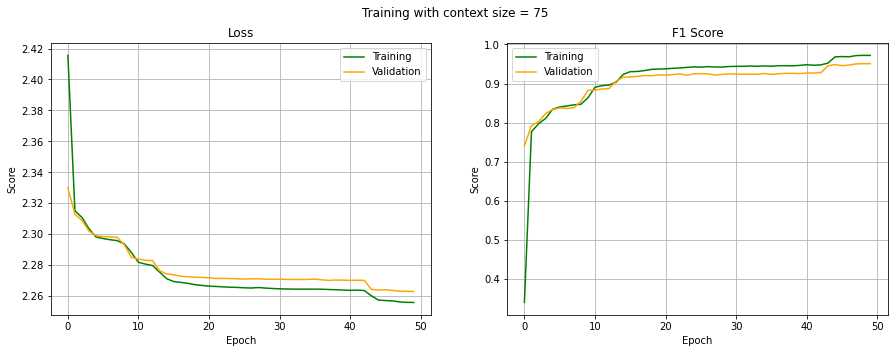

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9727, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9501, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9727, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9501, device='cuda:0'))

## Heatmap

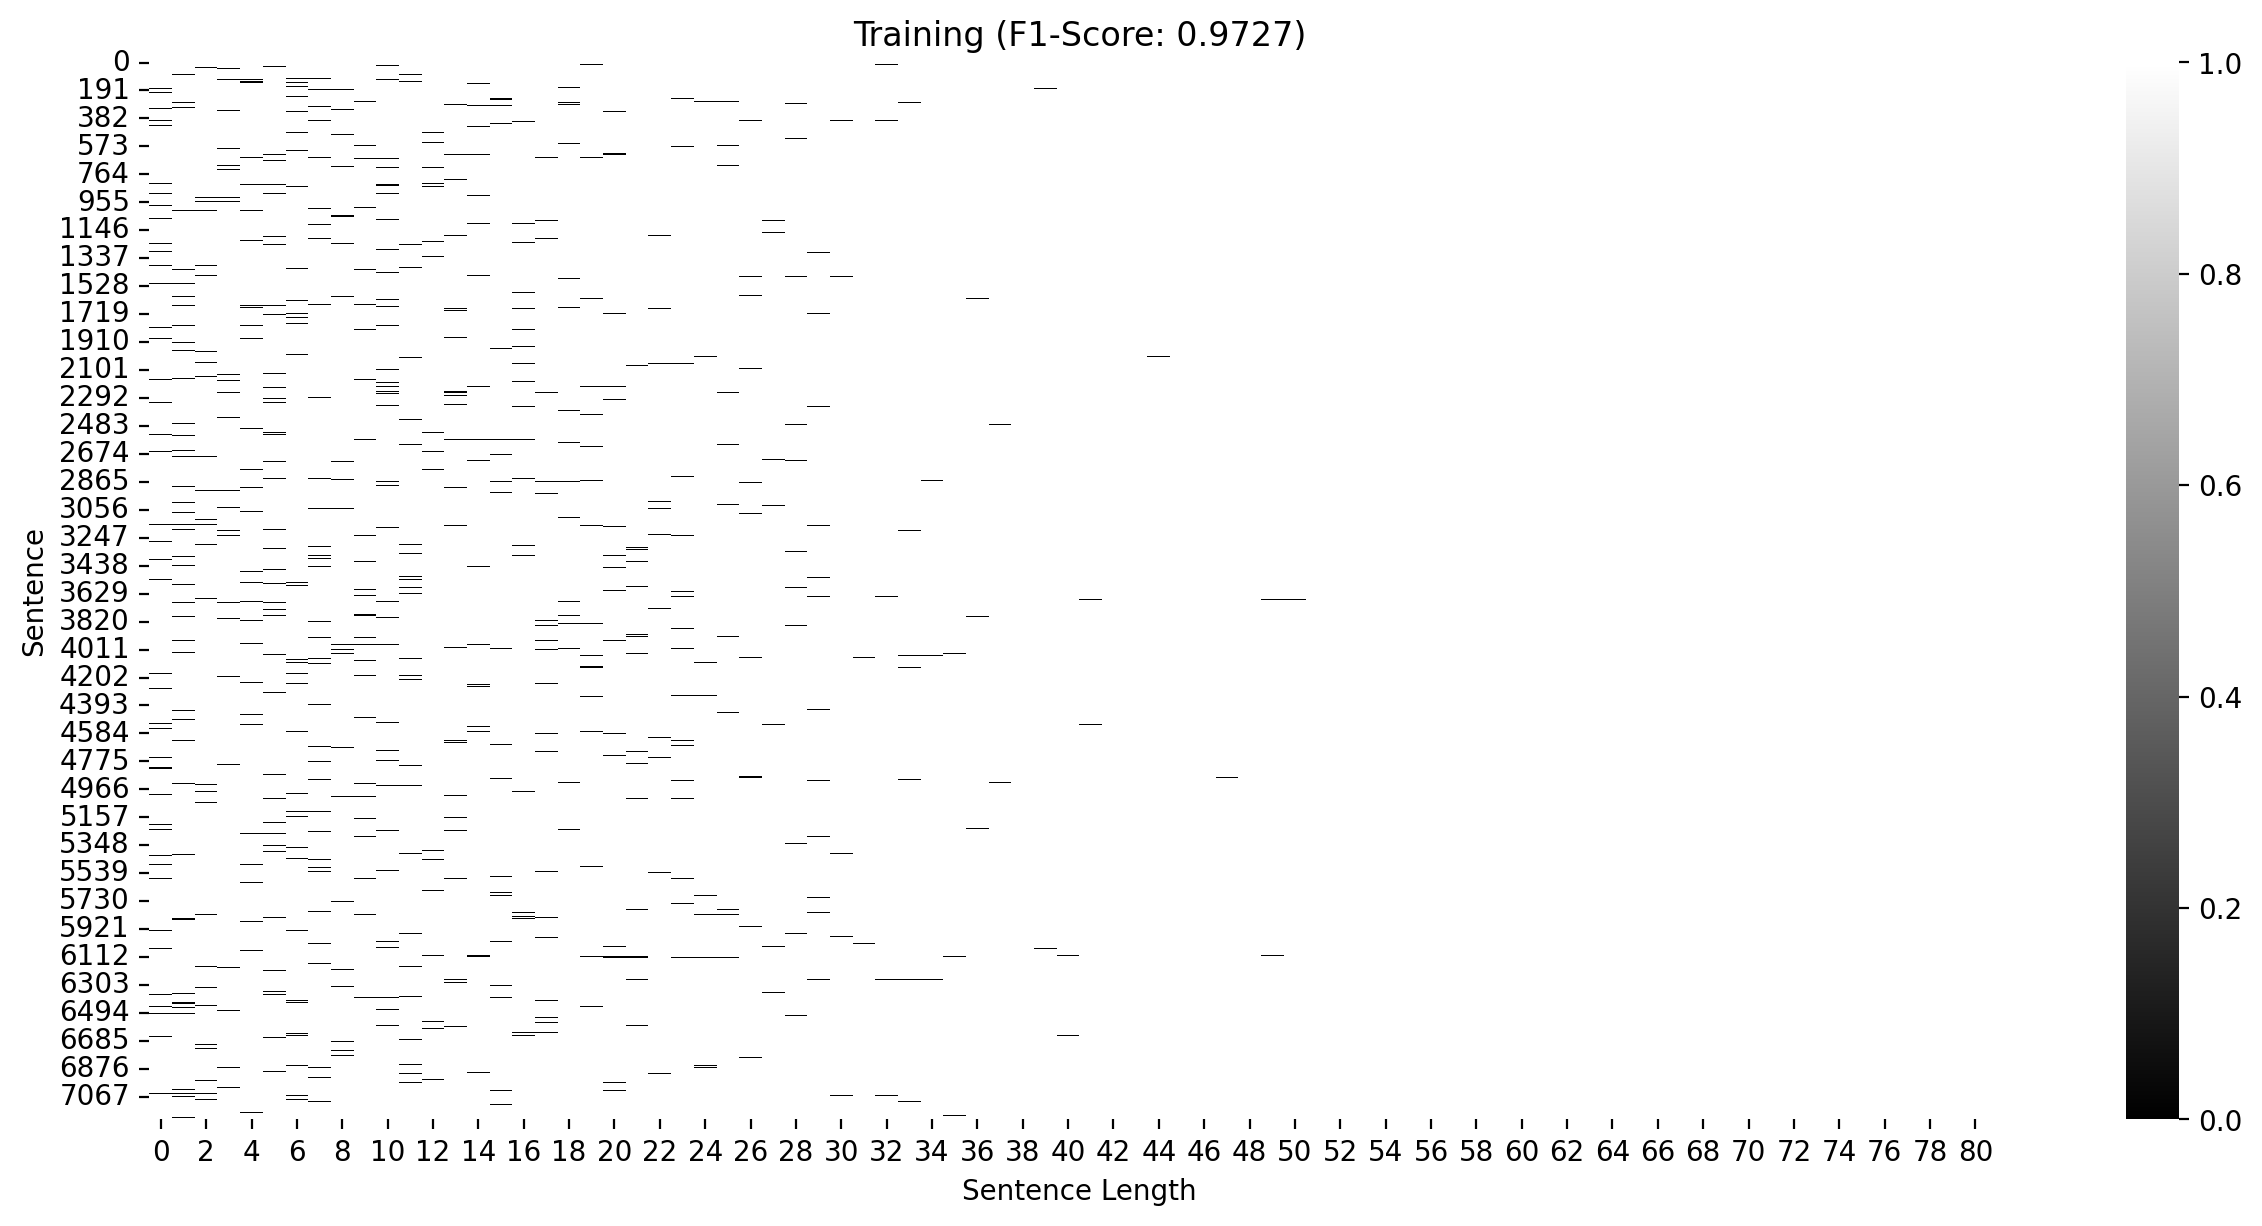

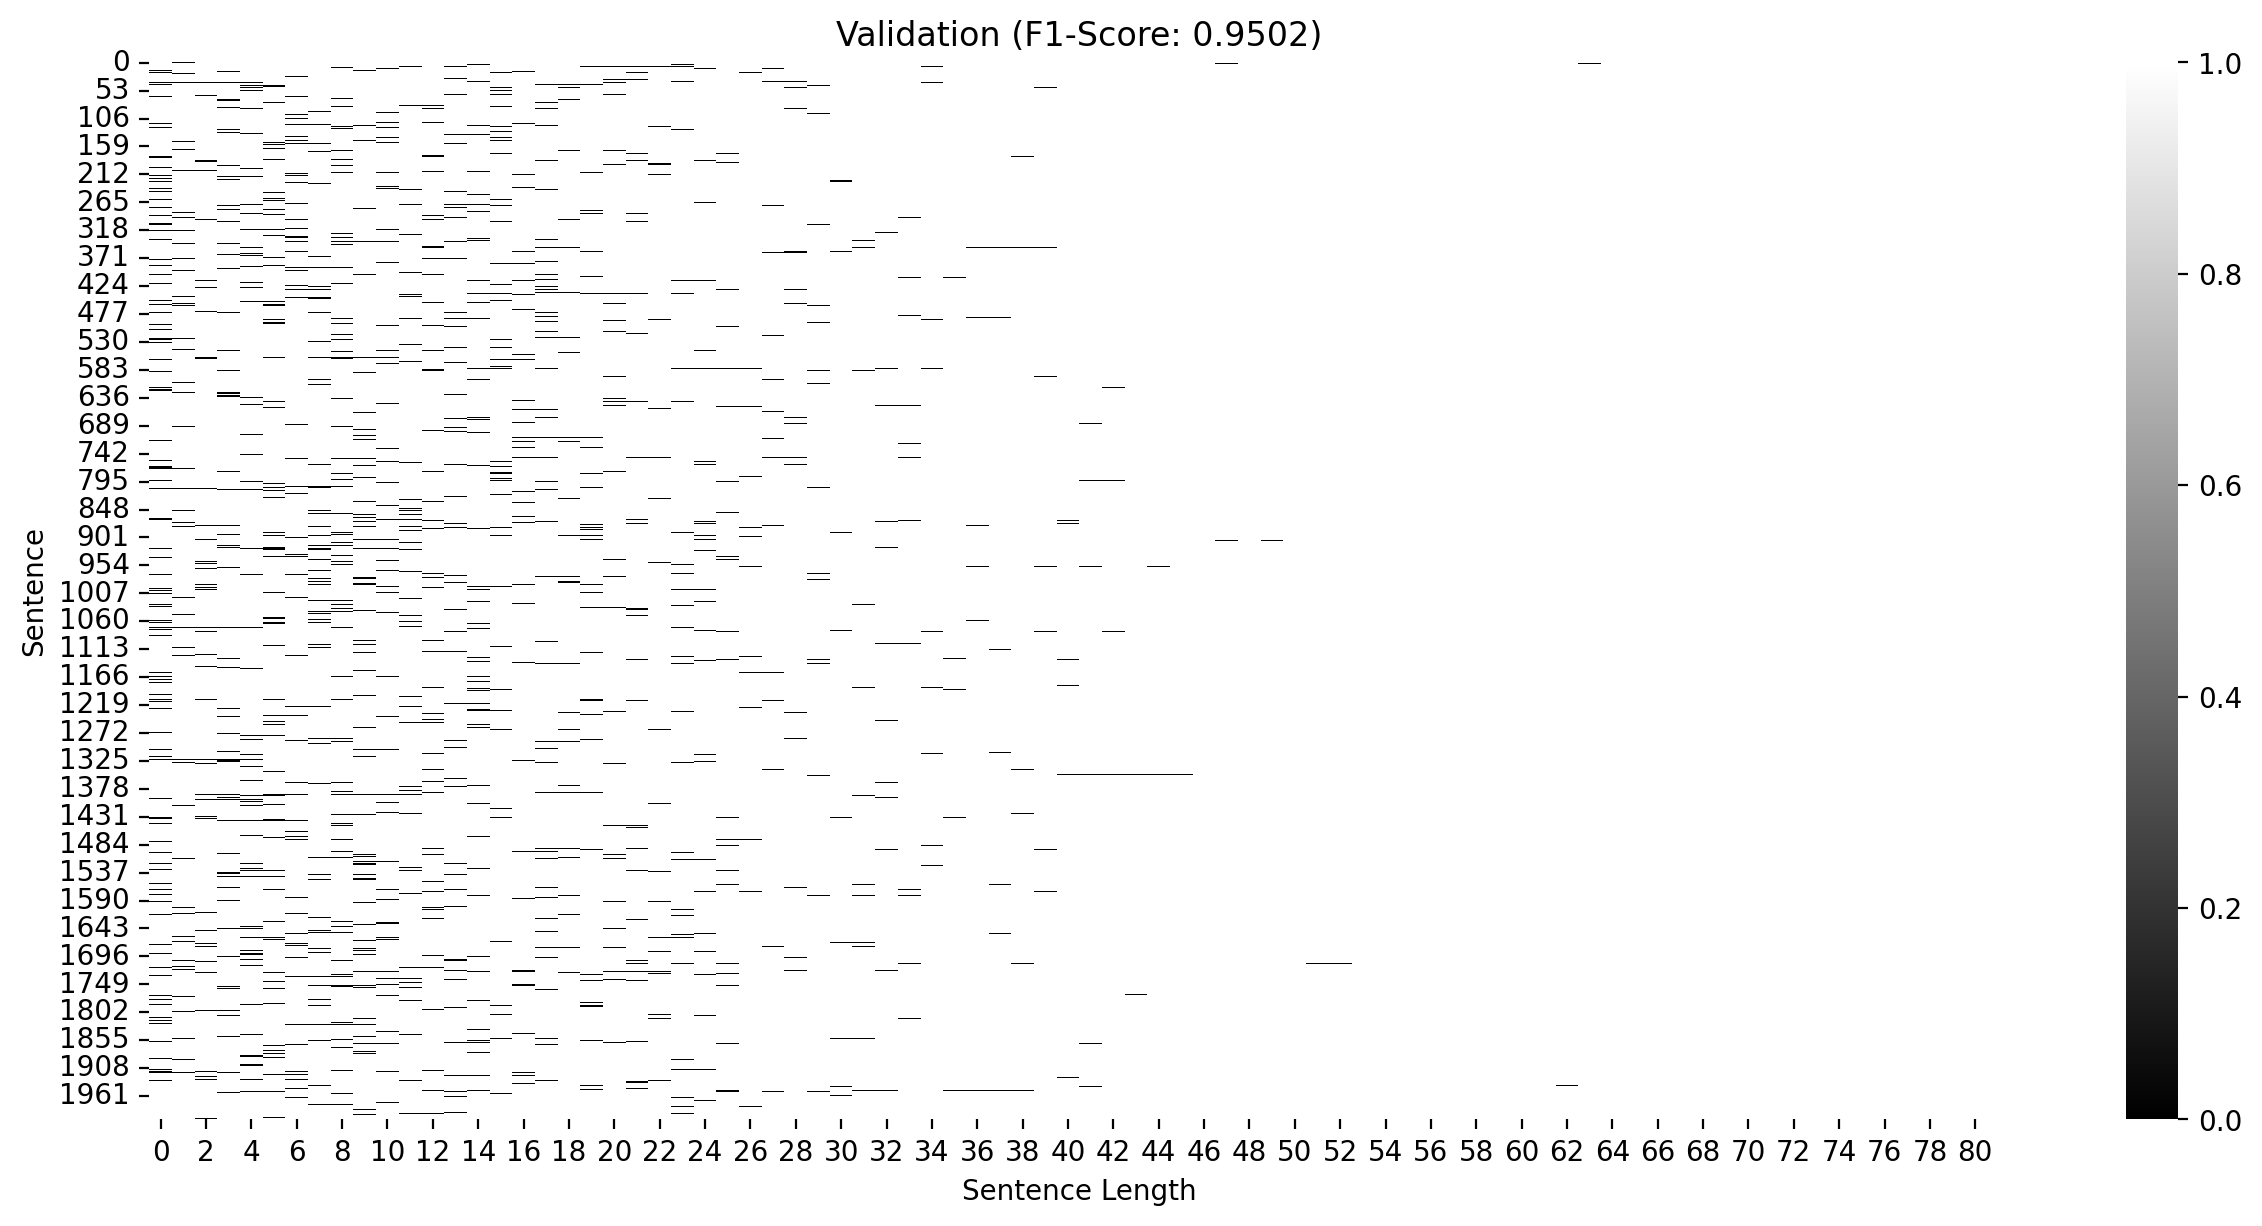

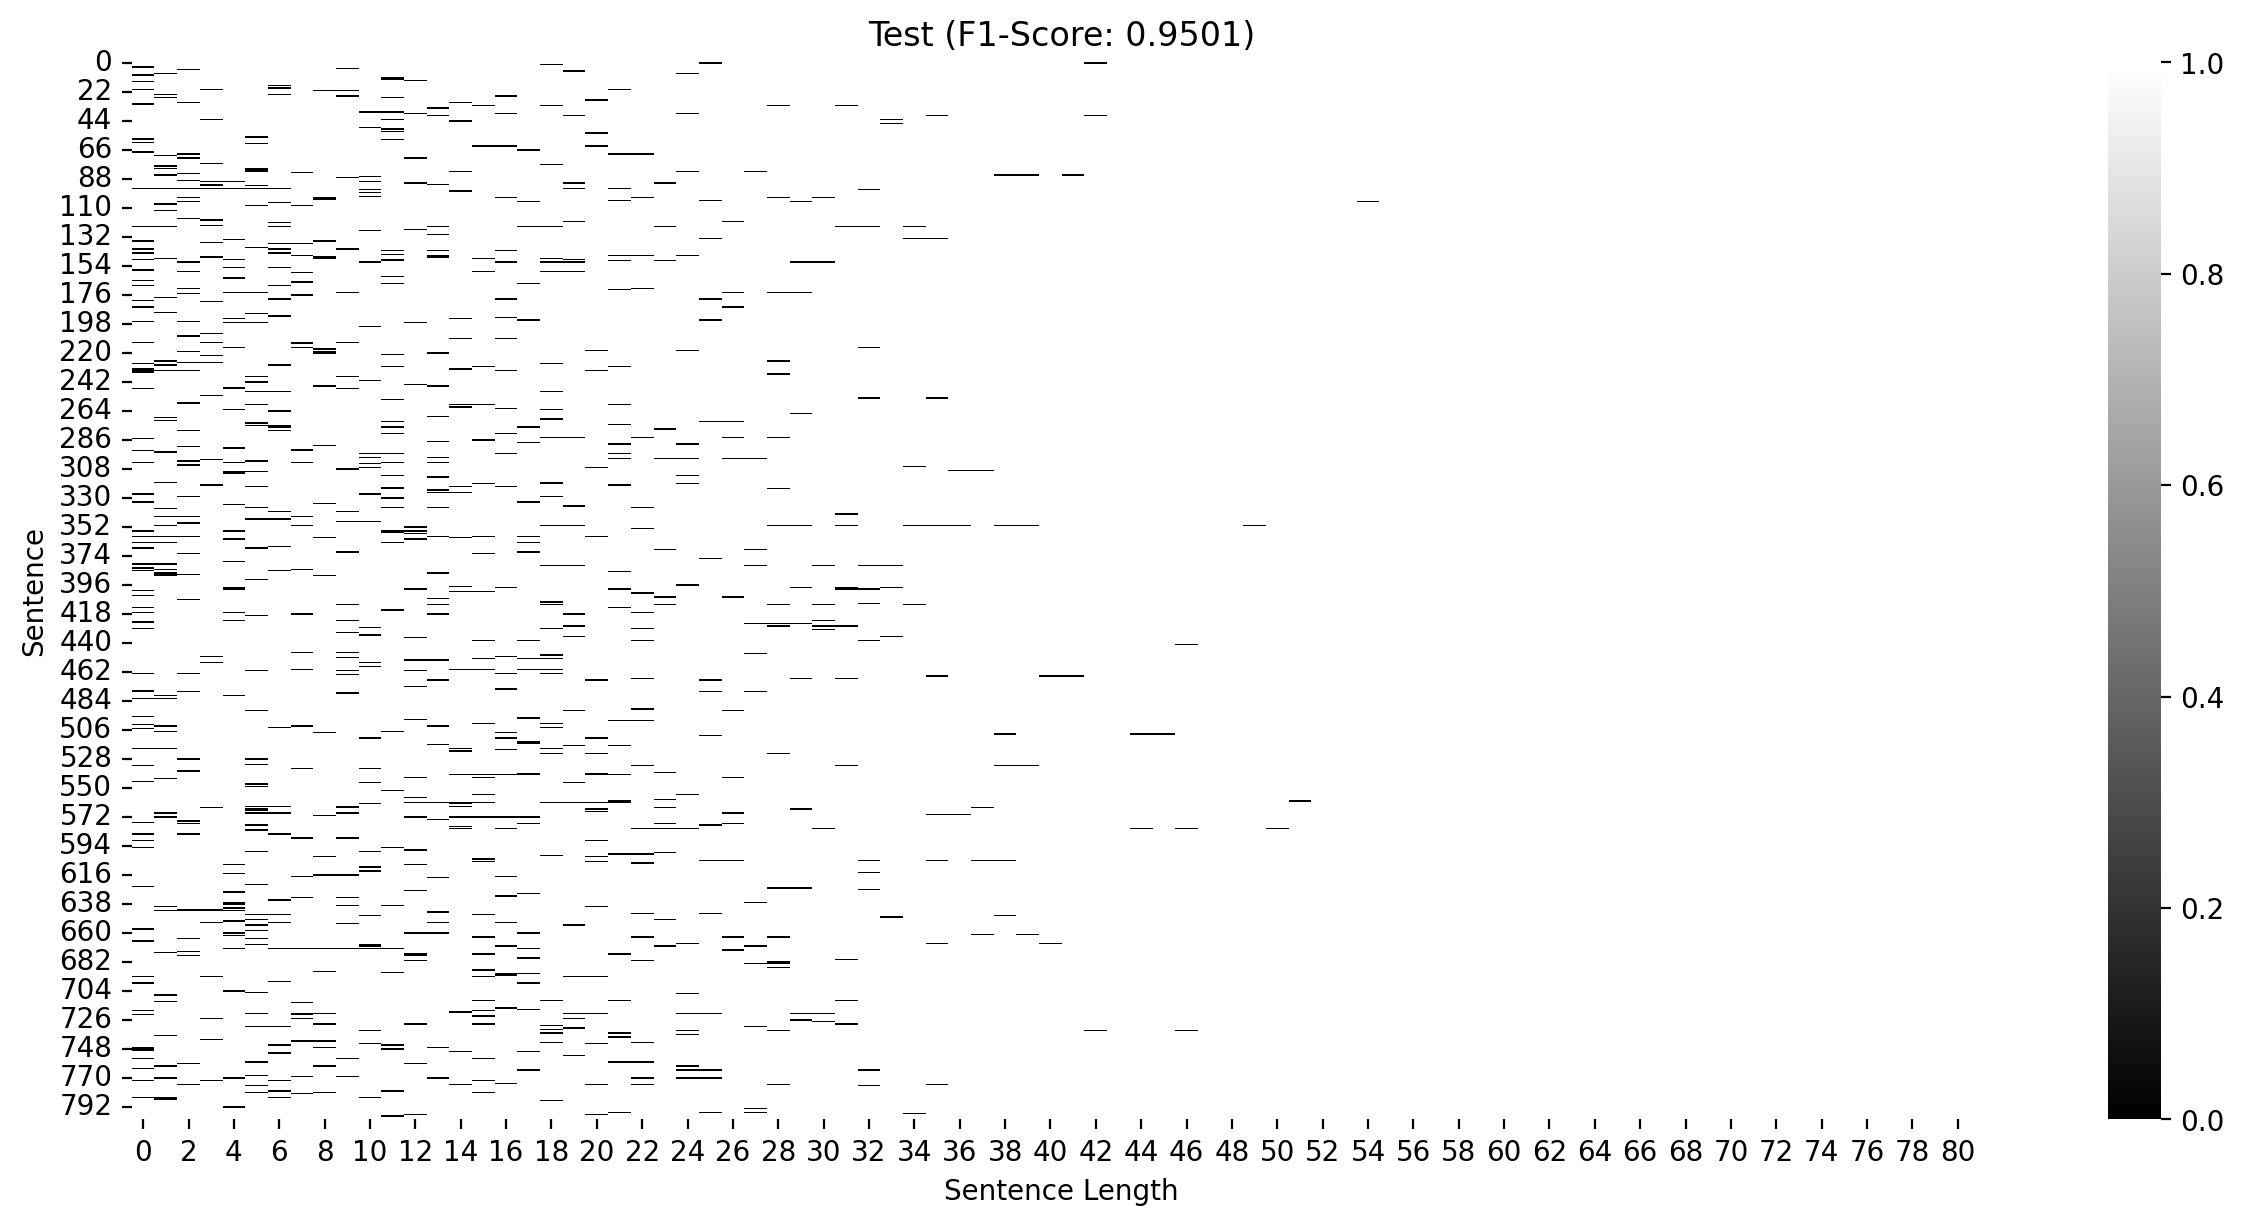

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


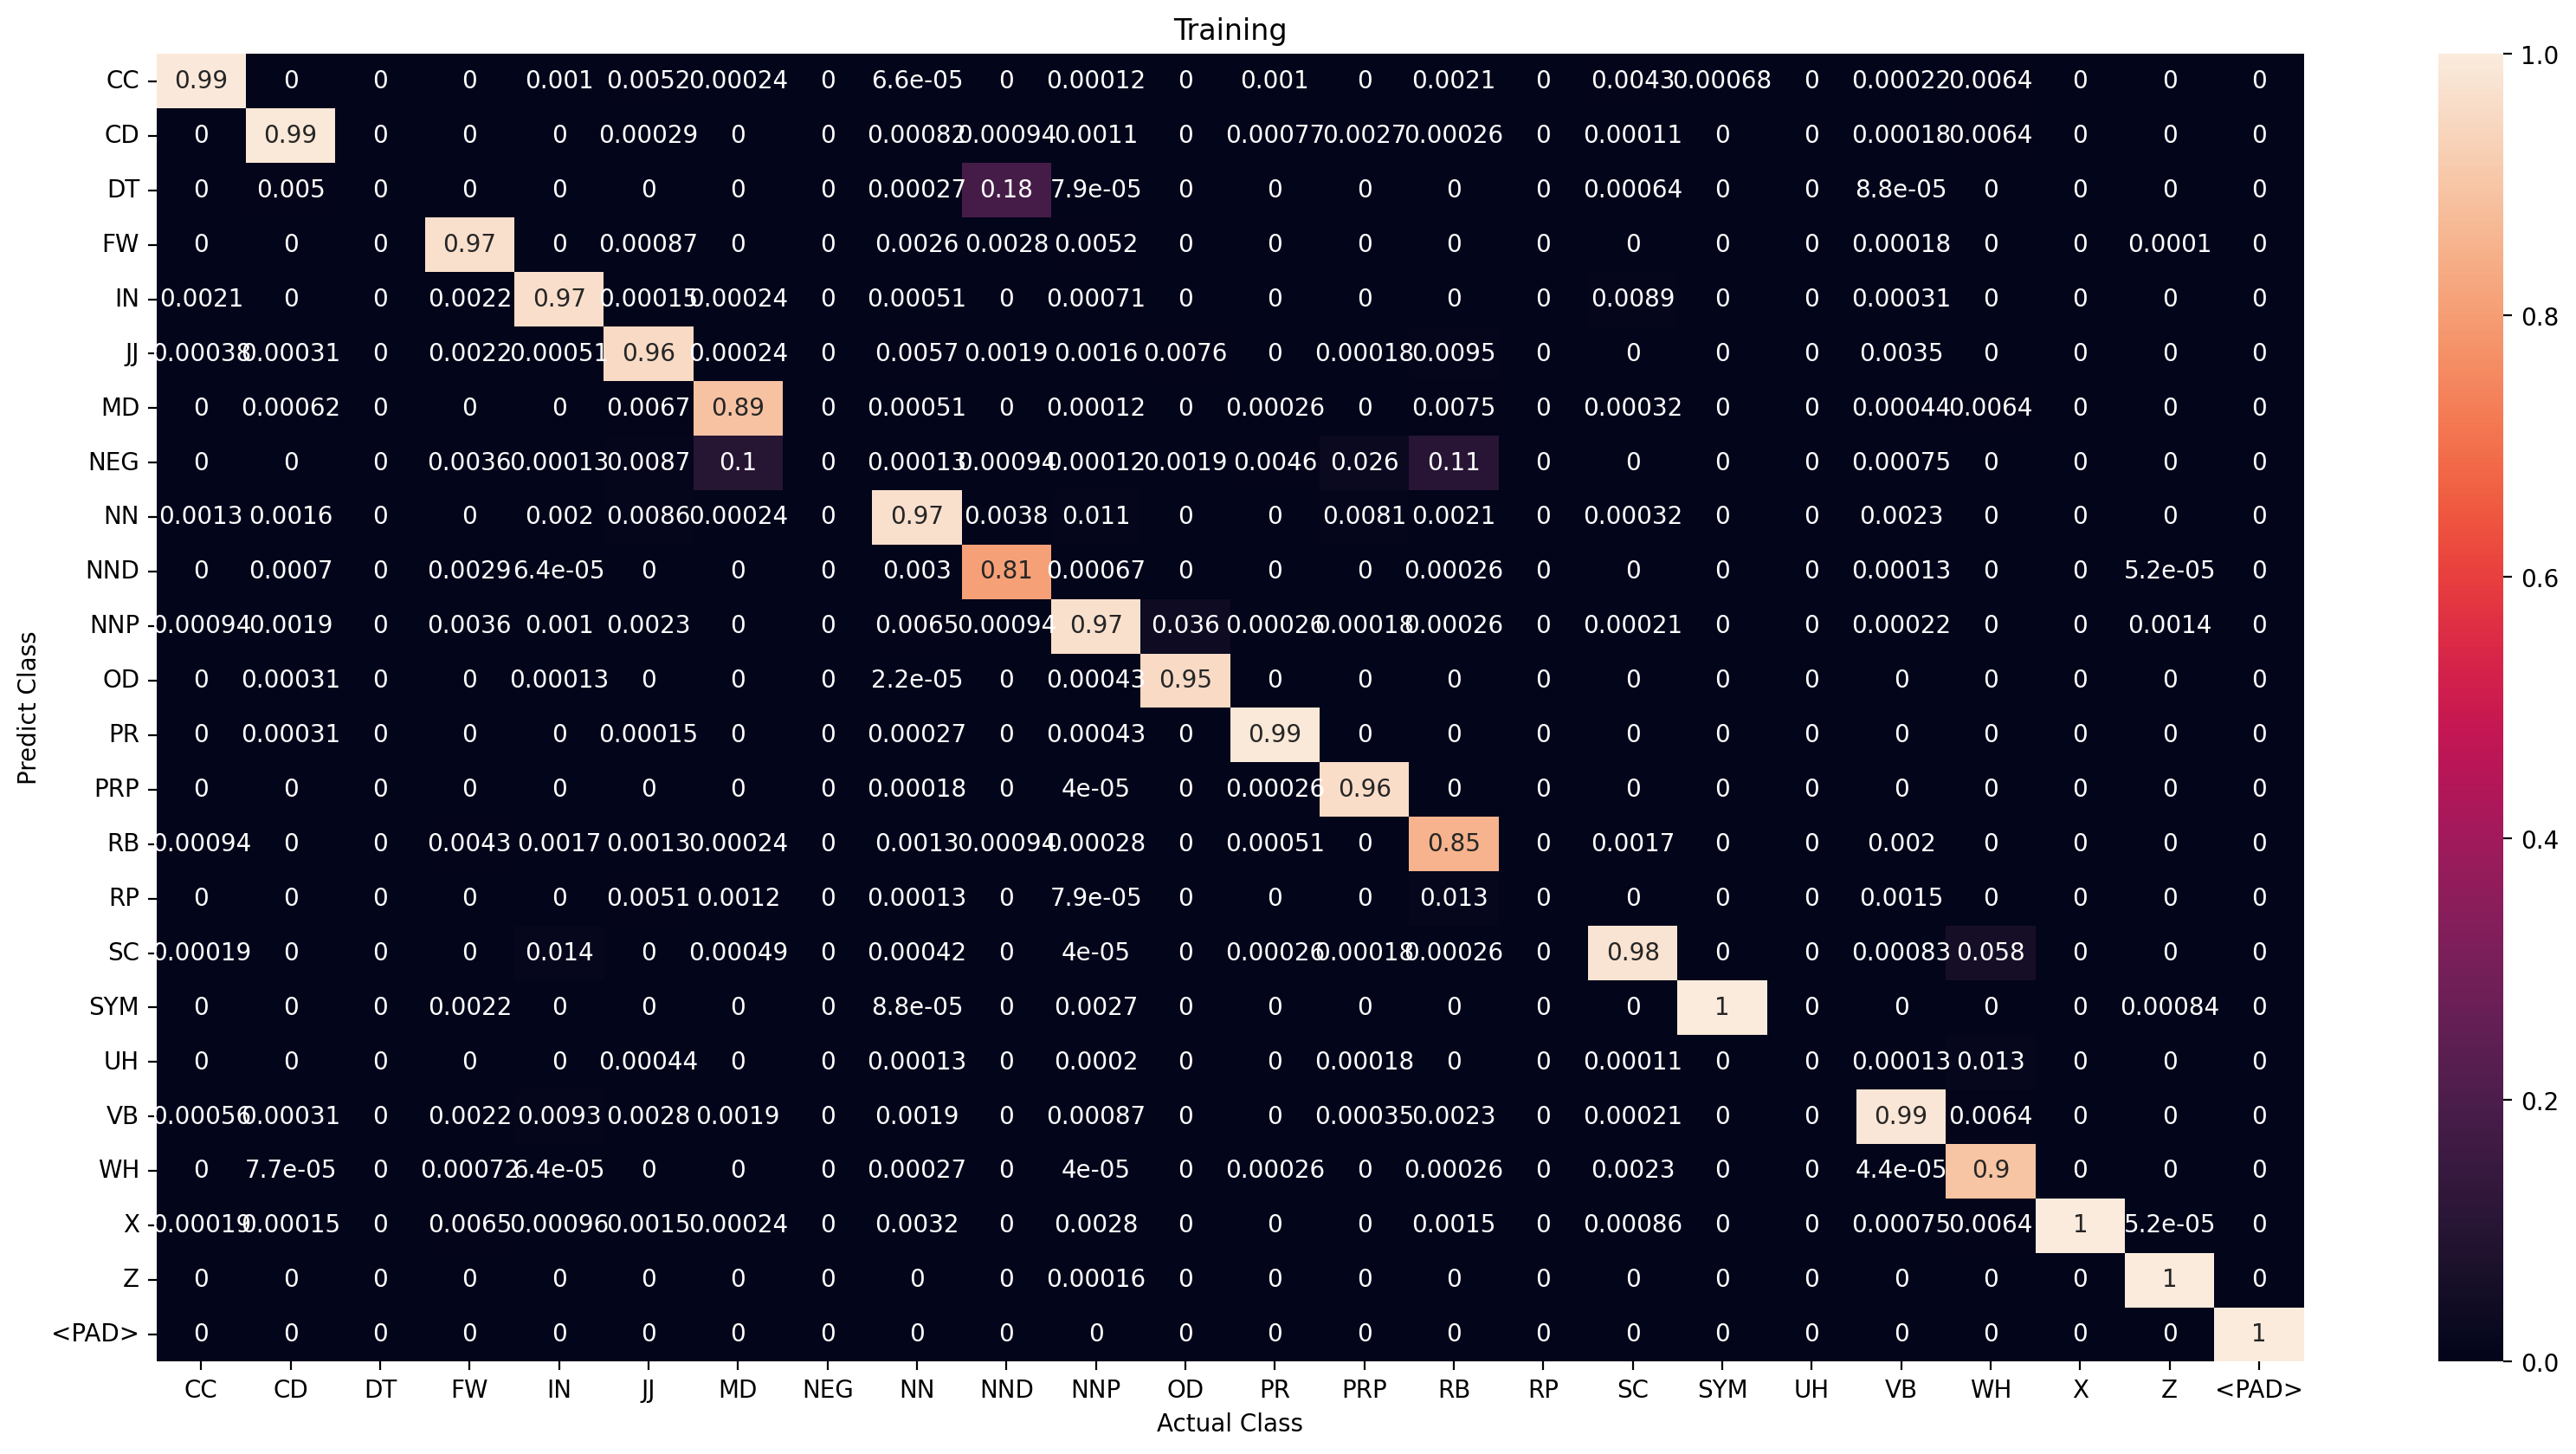

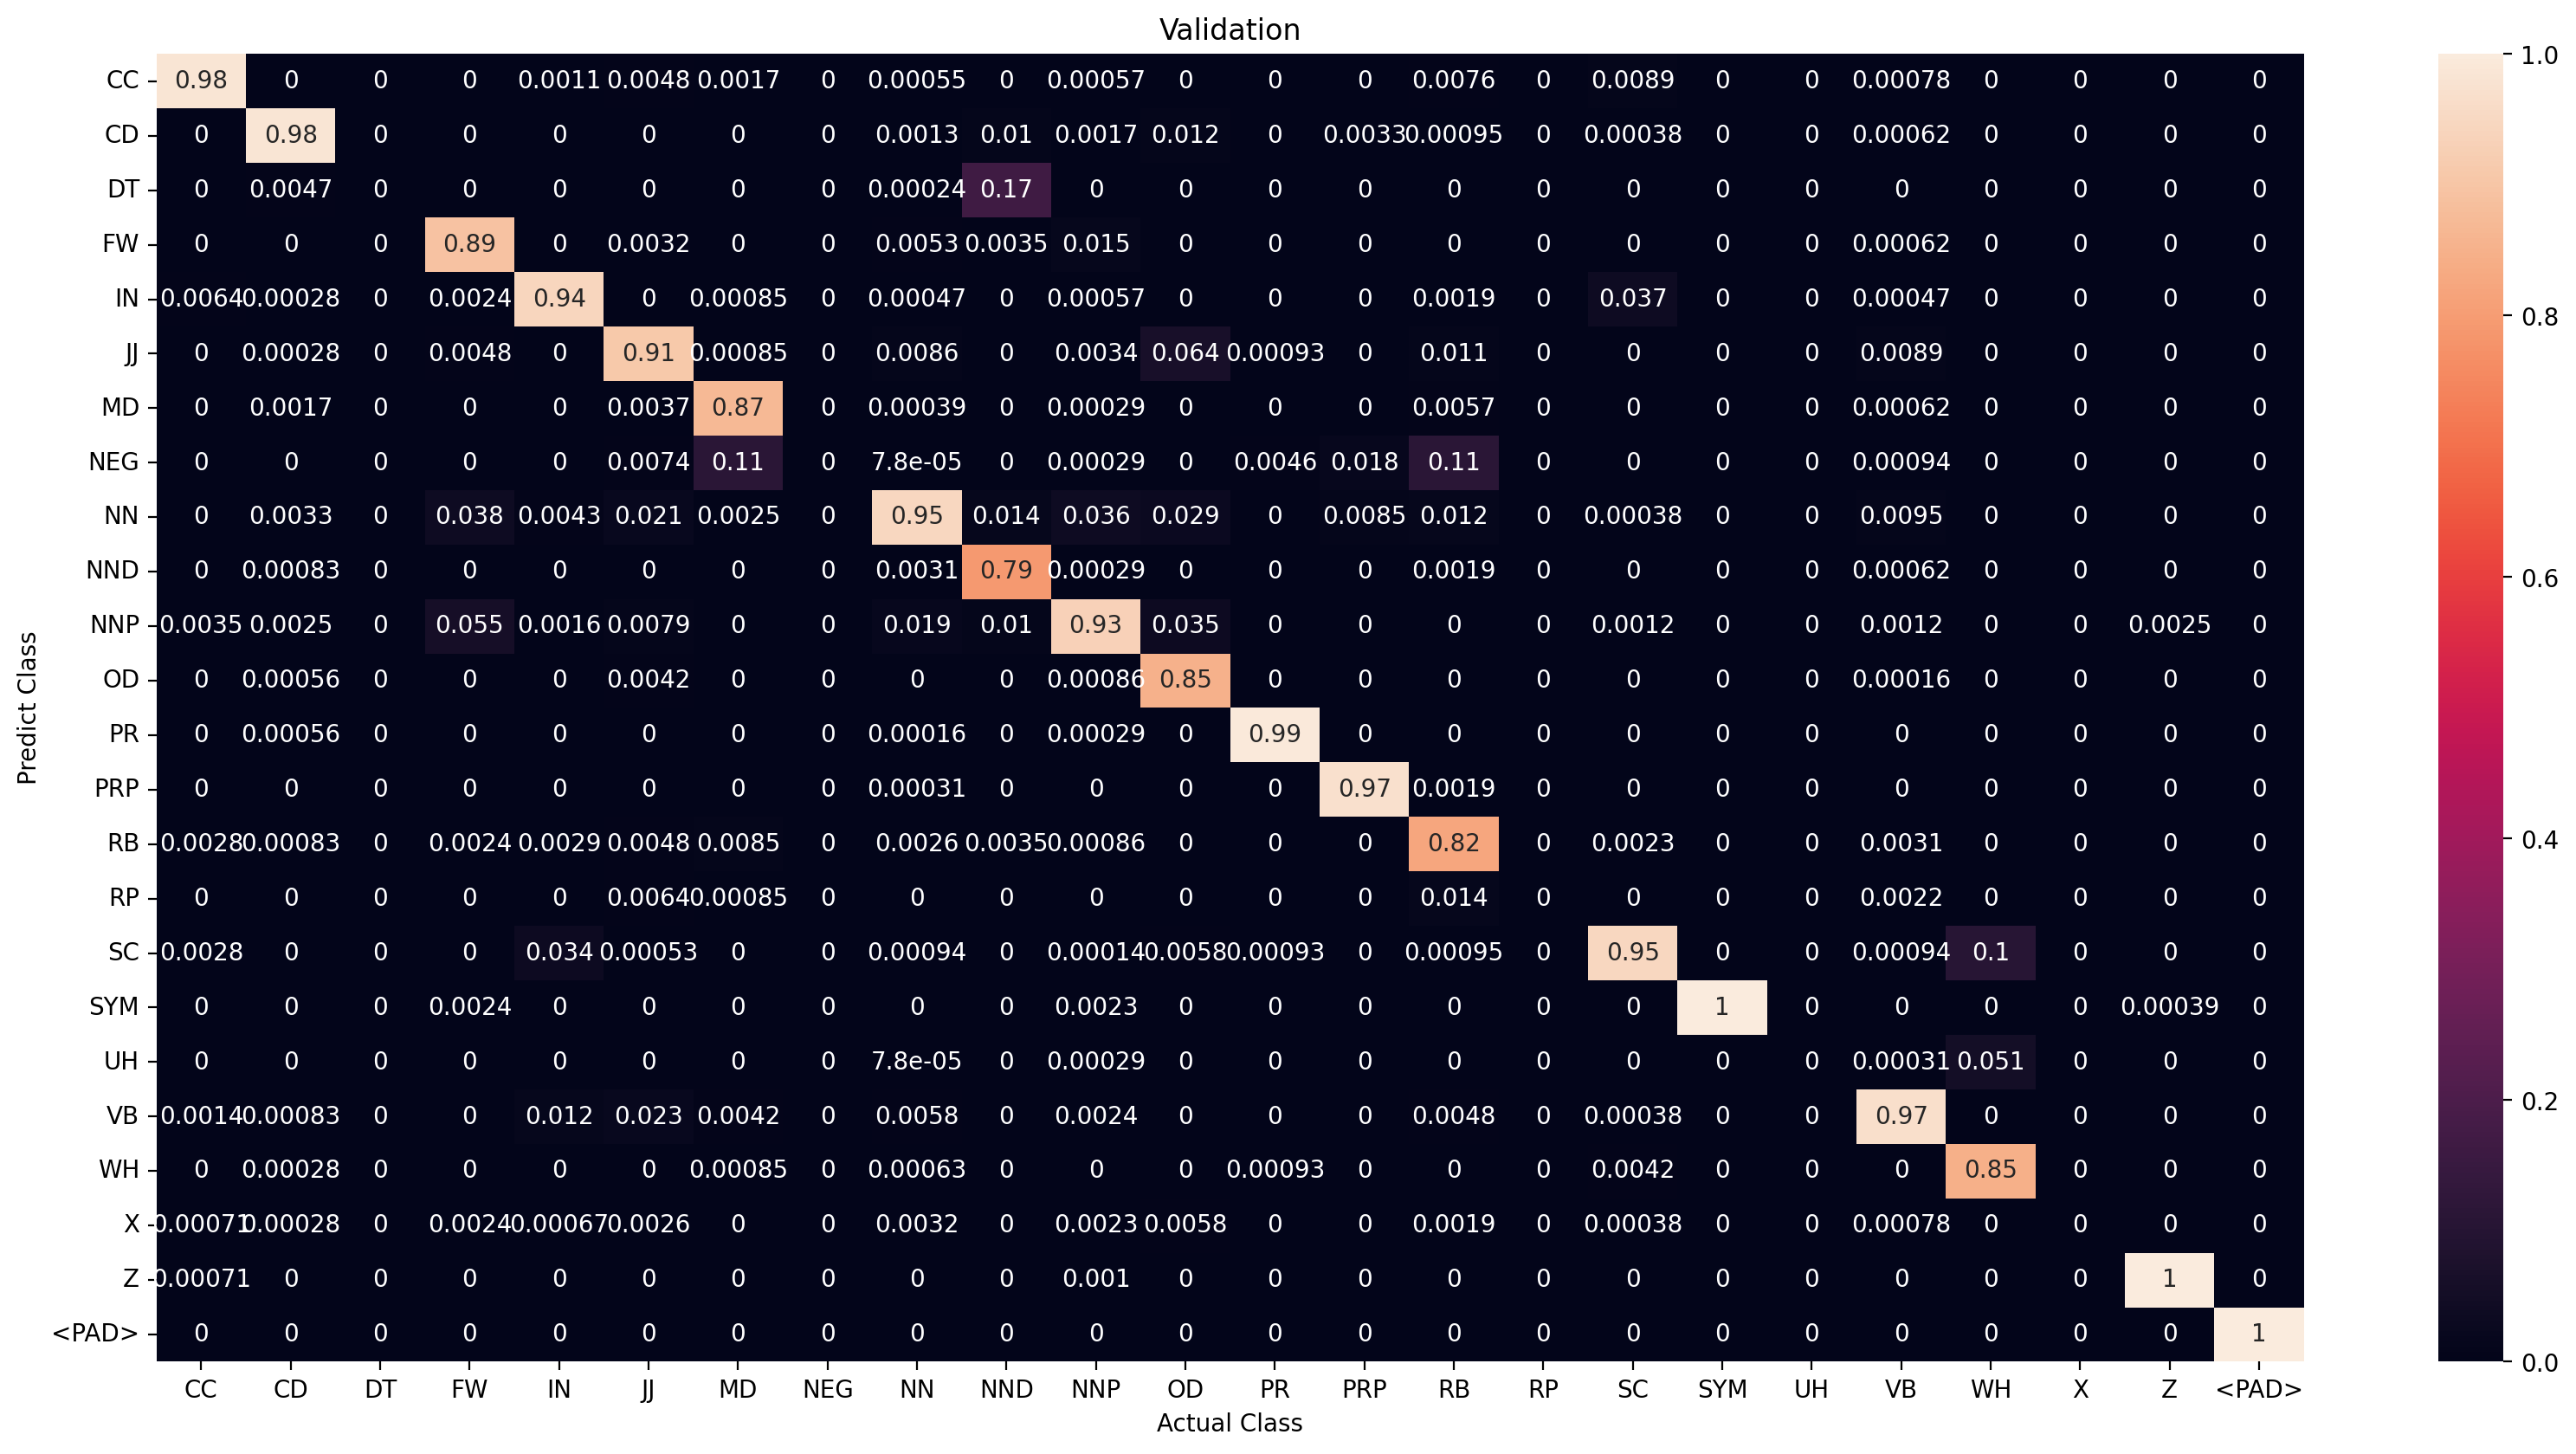

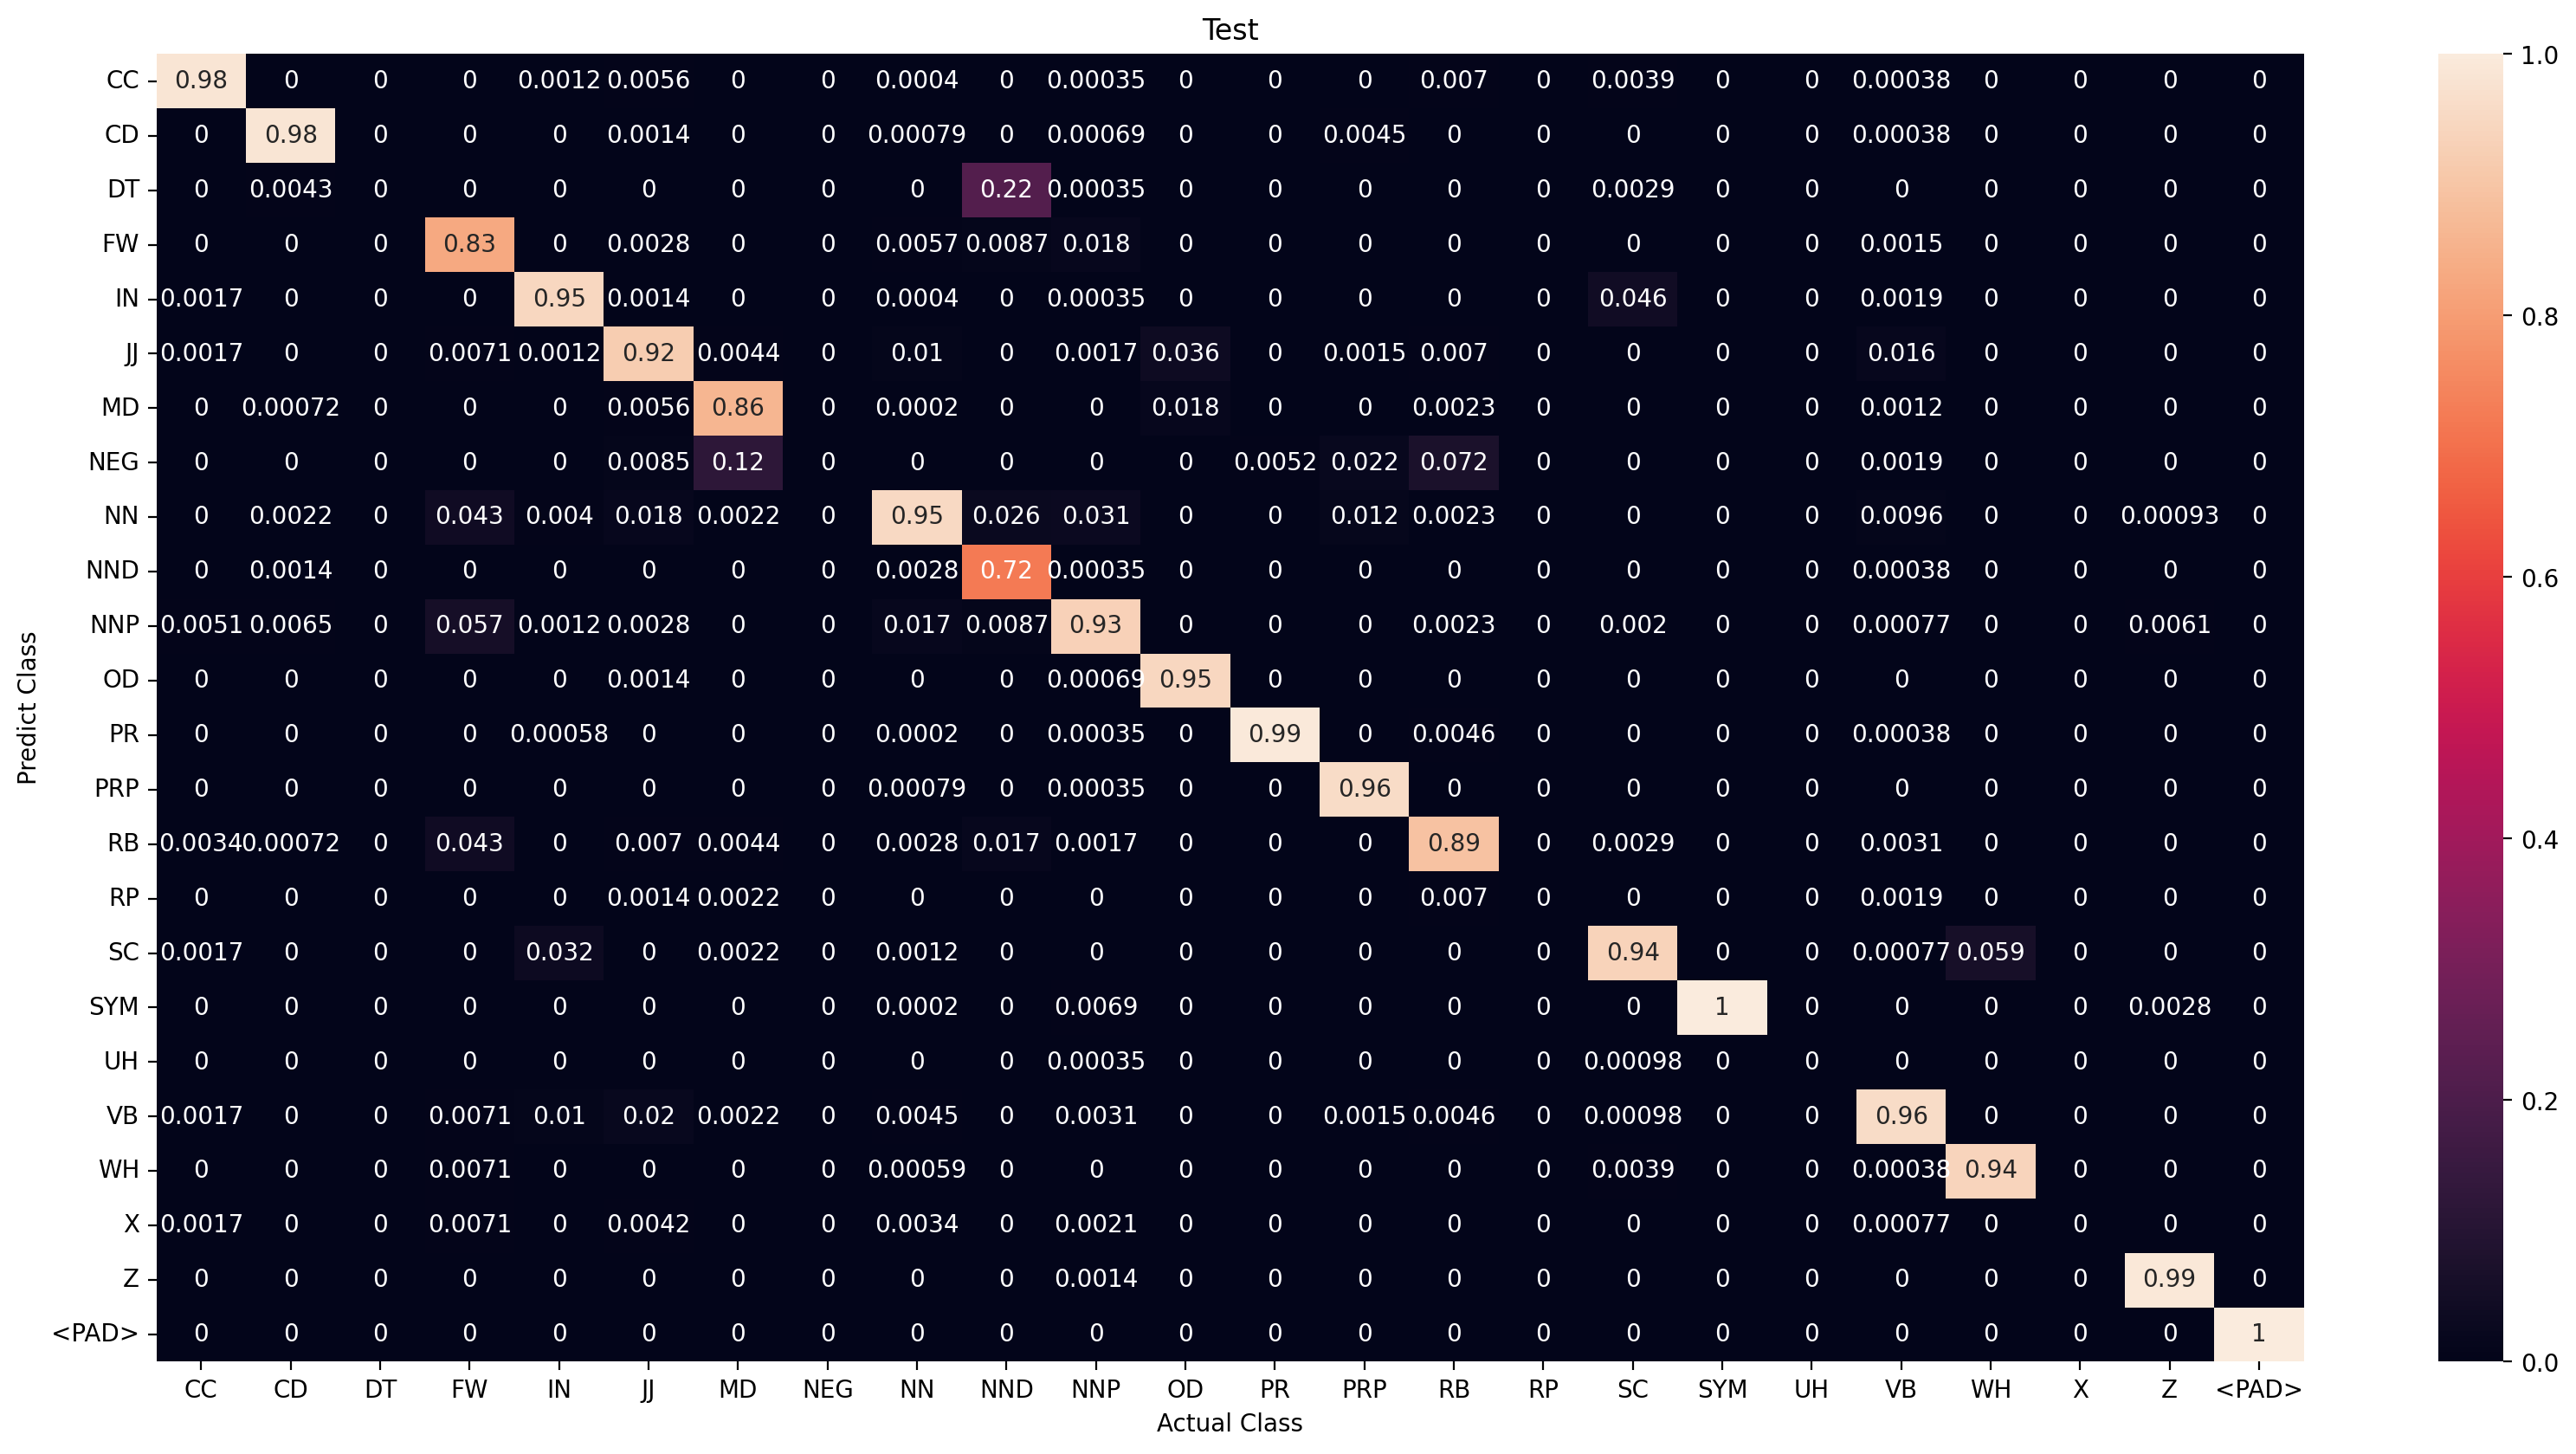

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5279       | CC    : 118      |
| CD    : 12862  | CD    : 12770      | CD    : 92       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1342       | FW    : 263      |
| IN    : 15290  | IN    : 15143      | IN    : 147      |
| JJ    : 7025   | JJ    : 6584       | JJ    : 441      |
| MD    : 3798   | MD    : 3674       | MD    : 124      |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43972      | NN    : 500      |
| NND   : 1033   | NND   : 861        | NND   : 172      |
| NNP   : 25007  | NNP   : 24588      | NNP   : 419      |
| OD    : 519    | OD    : 501        | OD    : 18       |
| PR    : 3880   | PR    : 3852       | PR    : 28       |
| PRP   : 5449   | PRP   : 5439       | PRP   : 10       |
| RB    : 3502   | RB    : 3325       | RB    : 177      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11217
Wrong prediction            : 754
Percentage correct oov pred : 93.70144515913458

Validation
Number OOV token            : 3190
Correct prediction          : 2860
Wrong prediction            : 330
Percentage correct oov pred : 89.65517241379311

Test
Number OOV token            : 1401
Correct prediction          : 1254
Wrong prediction            : 147
Percentage correct oov pred : 89.50749464668094



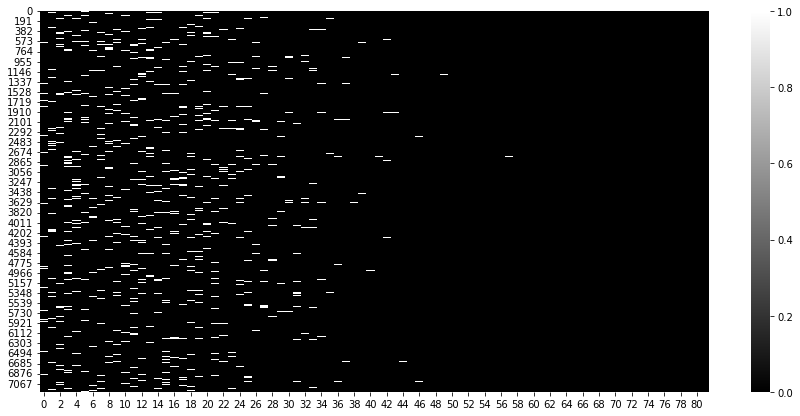

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

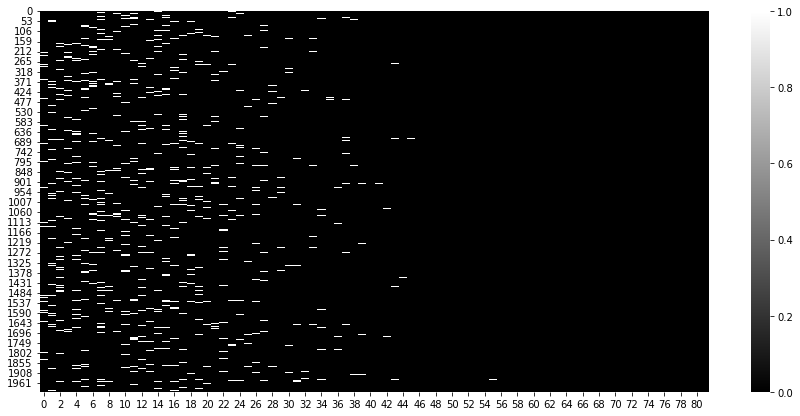

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

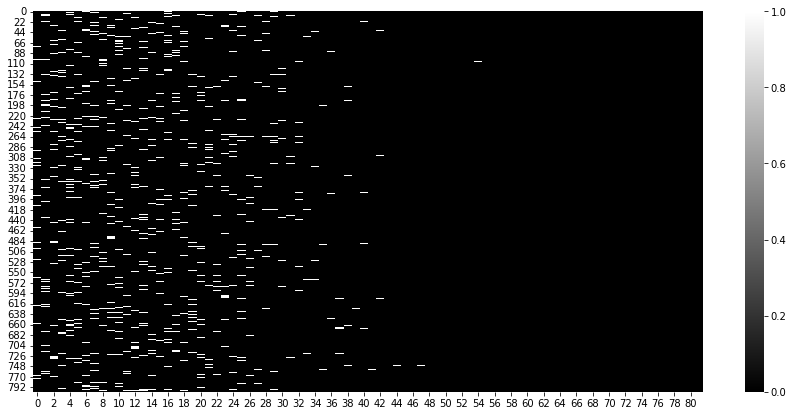

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);